# Deep reinforcement learning applied to the monte carlo paths

In [516]:
import numpy as np
from scipy.linalg import eig, inv, cholesky
from OU_simulation import *
from Policy_Gradient_agent import *
from TD3 import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import odeint
%reload_ext autoreload
%autoreload 2

In [31]:
# Same parameters are used as in the paper 
N       = 1
T       = 40
L       = 1000
delta_t = T/L
theta   = np.diag(np.random.normal(0.5, 0.1, N))
mu      = np.zeros((N,1))
sigma   = np.random.uniform(-0.3,0.3,(N,N))
sigma   = sigma - np.diag(sigma.diagonal()) + np.diag(np.random.uniform(0,0.5,N))

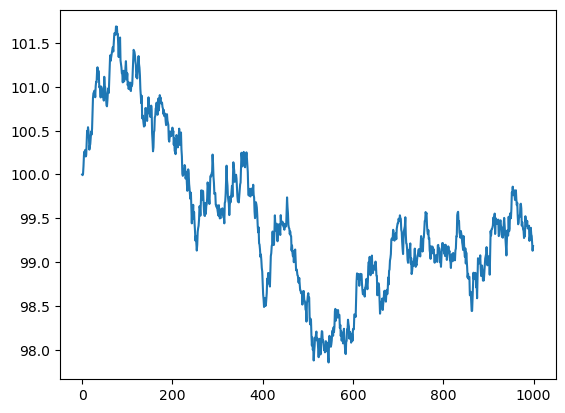

In [32]:
p = np.ones(N)
process  = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
test_env = TradingEnvironment(process,T,0,p, mode='portfolio')
test_env.reset()

done = False
while not done:
    state, reward, done, _ = test_env.step(np.ones(N))
plt.plot(test_env.W.transpose())

In [ ]:
r  = 0.02 # 0.2% interest rate
p  = np.ones((N,1)) #simplification in this model the asset prices themselves are assumed to be mean reverting
M  = 100 # amount of monte carlo simulations done
W0 = 0
process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
env     = TradingEnvironment(process,T,r,p)

def init_weights(m):
    """ Initializes the ANNs weights with a relevant distribution. """
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        #m.bias.data.fill_(0)

#### 3.1 Actor-Critic reinforcement learning 

First the policy and value models need to be created 

C-RL converges for 1 asset with hidden_dim=5 and learning_rate= 0.003
but does not converge for 100 assets with hidden_dim=500 and learning rate =0.0003

In [ ]:
LEARNING_RATE = 0.03
MAX_EPISODES = 300
DISCOUNT_FACTOR = 0
N_TRIALS = 25

INPUT_DIM  = N#2 * N + 1# first N input values is X_t and the next is pi_t
HIDDEN_DIM = 5
OUTPUT_DIM_ACTOR = N
OUTPUT_DIM_CRITIC = 1

policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

# init agent
actor = PolicyModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_ACTOR)
critic = ValueModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_CRITIC)
agent = ActorCritic(actor, critic)

agent.apply(init_weights)
optimizer = optim.Adam(agent.parameters(), lr = LEARNING_RATE)

process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
train_env = TradingEnvironment(process,T,r,p)
train_env.eval()
eval_env = TradingEnvironment(process,T,r,p)
eval_env.eval()

for episode in range(1, MAX_EPISODES+1):
    policy_loss, value_loss, train_reward = train(train_env, agent, optimizer, DISCOUNT_FACTOR)
    test_reward = evaluate(eval_env, agent, False)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)
    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    plot(episode, train_rewards, policy_losses, value_losses)

NameError: name 'N' is not defined

#### 3.2 Proximal Policy Optimisation (PPO)

Using only $X_t$ as a state feature and $\alpha$ = 0

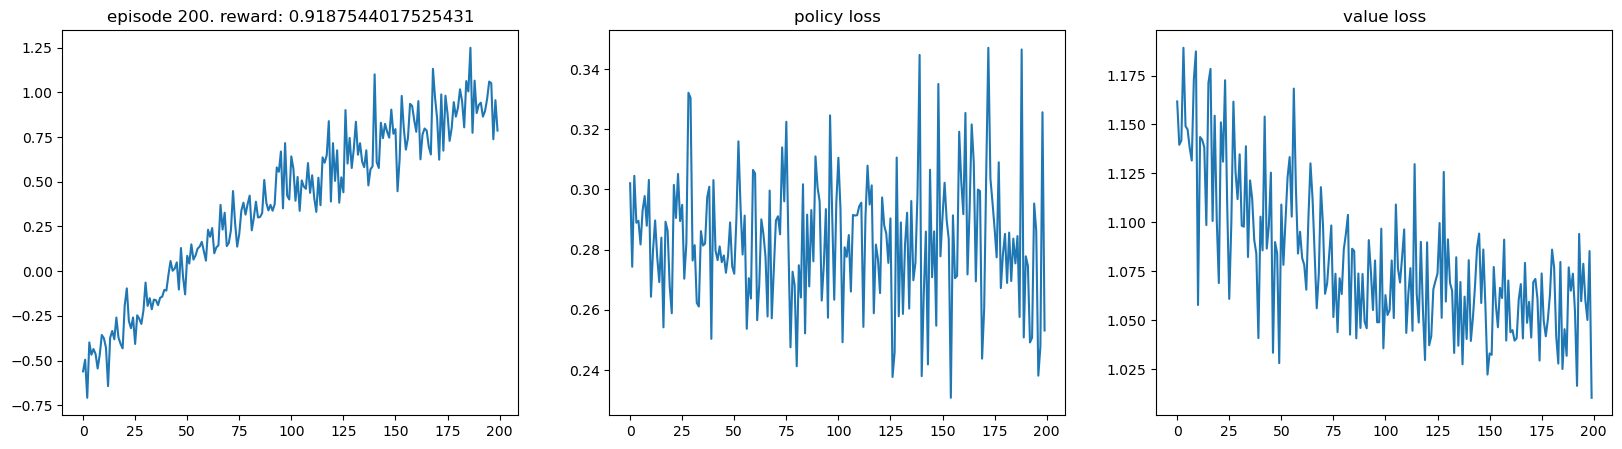

In [ ]:
MAX_EPISODES = 200
LEARNING_RATE = 0.0001
DISCOUNT_FACTOR = 0.0
N_TRIALS = 25
PPO_STEPS = 5
PPO_CLIP = 0.2

INPUT_DIM  = N # first N input values is X_t and the next is pi_t
HIDDEN_DIM = 50  #2*N+1
OUTPUT_DIM_ACTOR = N
OUTPUT_DIM_CRITIC = 1

policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
r = 0
train_env = TradingEnvironment(process,T,r,p,mode='portfolio', max_pi=10, max_change=5)
eval_env = TradingEnvironment(process,T,r,p,mode='portfolio', max_pi=10, max_change=5)

# init agent
actor = PolicyModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_ACTOR,dropout=0.3)
critic = ValueModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_CRITIC, dropout=0.3)
agent = ActorCritic(actor, critic)
agent.apply(init_weights)
optimizer = optim.Adam(agent.parameters(), lr = LEARNING_RATE)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train_ppo(train_env, agent, optimizer,scheduler, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP)
    
    test_reward = evaluate(eval_env, agent)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)

    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    plot(episode, test_rewards, policy_losses, value_losses)

Text(0.5, 1.0, 'sample path of $W_t$')

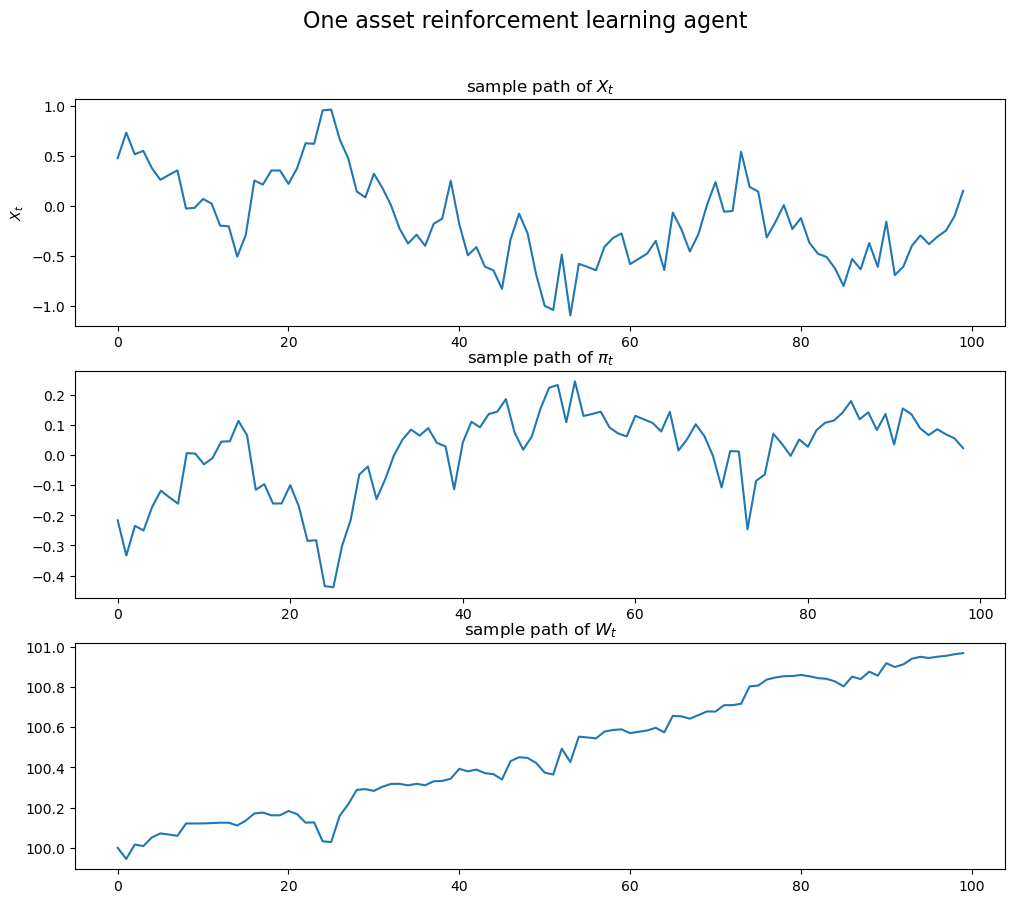

In [ ]:
state,_ = train_env.reset()
done = False
val_predictions = []
while not done:
    state = torch.FloatTensor(state['values']).unsqueeze(0)
    action, _, value_pred = agent.forward(state)
    val_predictions.append(value_pred.detach().item())
    state, reward, done, _ = train_env.step(action.detach().numpy())
    
fig, ax = plt.subplots(3,1,figsize=(12,10))
fig.suptitle('One asset reinforcement learning agent', fontsize=16, y = 0.97)
# plot a sample path of the wealth
ax[0].plot(train_env.X.transpose())
ax[0].set_title(r'sample path of $X_t$')
ax[0].set_ylabel(r'$X_t$')
#ax[0].set_xlabel('Time')
ax[1].plot(np.array(train_env.alloc).sum(axis=1).reshape(-1))
ax[1].set_title(r'sample path of $\pi_t$')

ax[2].plot(train_env.W)
ax[2].set_title(r'sample path of $W_t$')


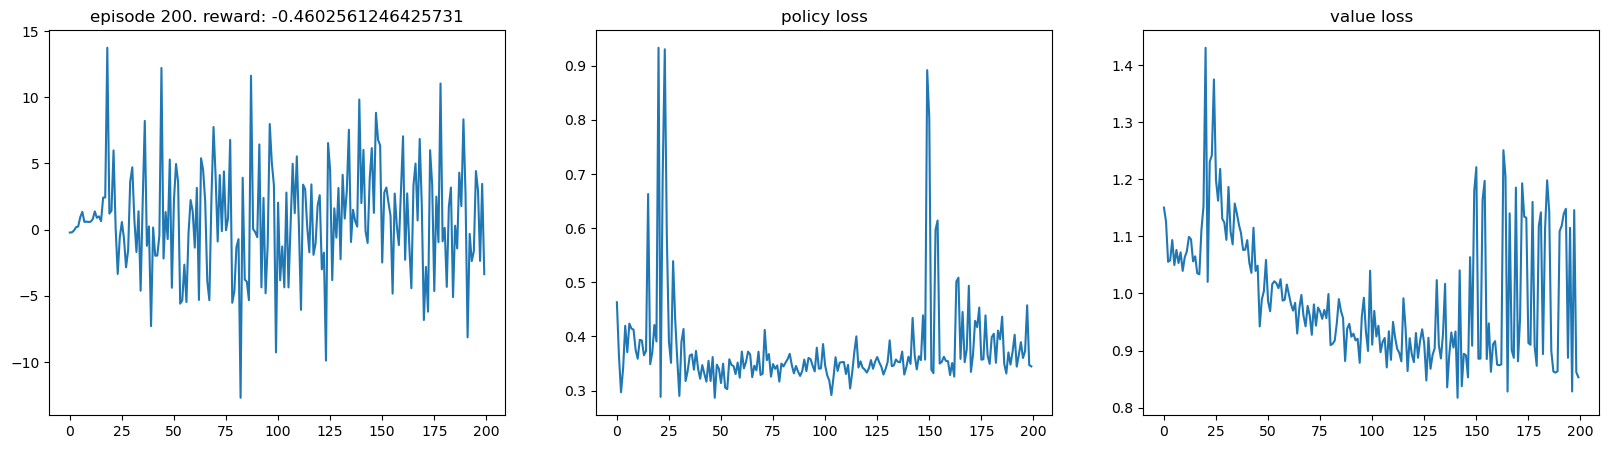

In [ ]:
MAX_EPISODES = 200
LEARNING_RATE = 0.0001
DISCOUNT_FACTOR = 0.99
N_TRIALS = 25
PPO_STEPS = 10
PPO_CLIP = 0.1

INPUT_DIM  = 2*N # first N input values is X_t and the next is pi_t
HIDDEN_DIM = 100  #2*N+1
OUTPUT_DIM_ACTOR = N
OUTPUT_DIM_CRITIC = 1

policy_losses = []
value_losses = []
train_rewards = []
test_rewards = []

process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
r = 0
train_env = TradingEnvironment(process,T,r,p,mode='intensity', max_pi=10, max_change=5)
eval_env = TradingEnvironment(process,T,r,p,mode='intensity', max_pi=10, max_change=5)

# init agent
actor = PolicyModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_ACTOR,dropout=0.3)
critic = ValueModel(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM_CRITIC, dropout=0.3)
agent = ActorCritic(actor, critic)
agent.apply(init_weights)
optimizer = optim.Adam(agent.parameters(), lr = LEARNING_RATE)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

for episode in range(1, MAX_EPISODES+1):
    
    policy_loss, value_loss, train_reward = train_ppo(train_env, agent, optimizer,scheduler, DISCOUNT_FACTOR, PPO_STEPS, PPO_CLIP)
    
    test_reward = evaluate(eval_env, agent)
    
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    policy_losses.append(policy_loss)
    value_losses.append(value_loss)

    
    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])
    
    plot(episode, test_rewards, policy_losses, value_losses)

Text(0.5, 1.0, 'sample path of $W_t$')

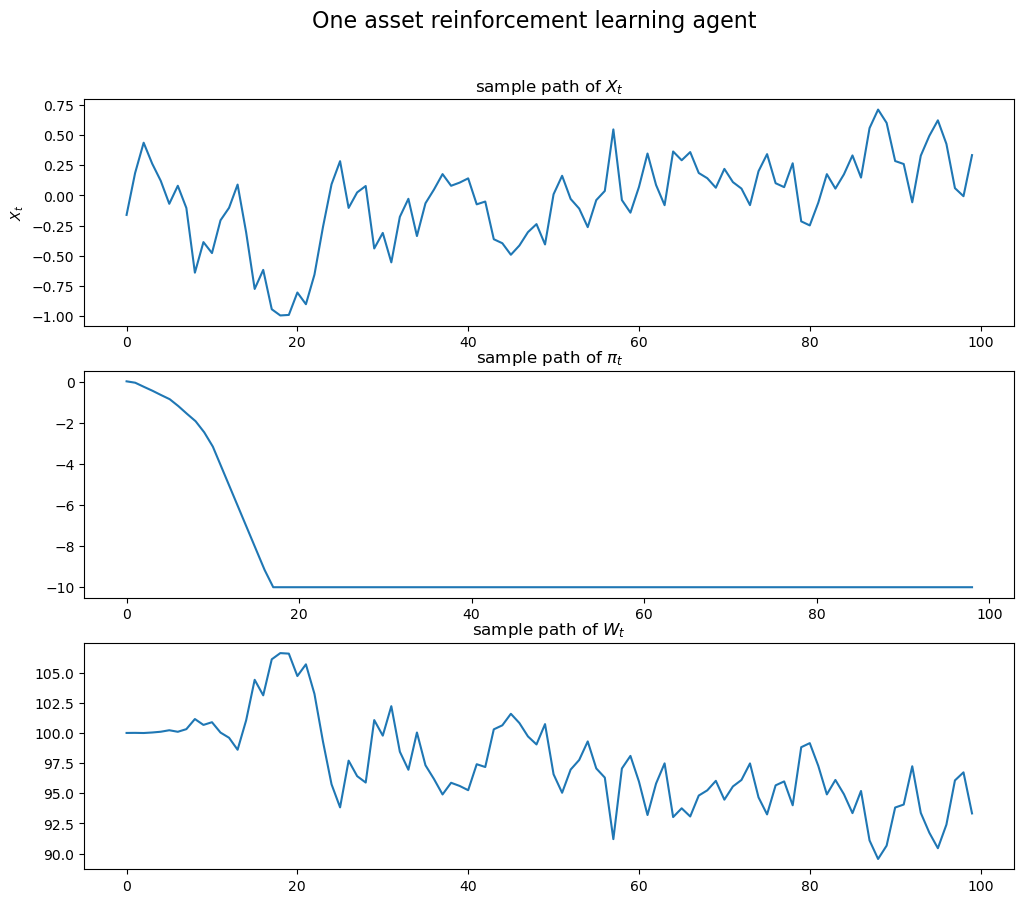

In [ ]:
state, _ = train_env.reset()
done = False
val_predictions = []
while not done:
    #state = torch.FloatTensor(state[:N]).unsqueeze(0)
    state = torch.cat((torch.FloatTensor(state['values']),torch.FloatTensor(state['portfolio']))).unsqueeze(0)


    action, _, value_pred = agent.forward(state)
    val_predictions.append(value_pred.detach().item())
    state, reward, done, _ = train_env.step(action.detach().numpy())
    
fig, ax = plt.subplots(3,1,figsize=(12,10))
fig.suptitle('One asset reinforcement learning agent', fontsize=16, y = 0.97)
# plot a sample path of the wealth
ax[0].plot(train_env.X.transpose())
ax[0].set_title(r'sample path of $X_t$')
ax[0].set_ylabel(r'$X_t$')
#ax[0].set_xlabel('Time')
ax[1].plot(np.array(train_env.alloc).sum(axis=1).reshape(-1))
ax[1].set_title(r'sample path of $\pi_t$')

ax[2].plot(train_env.W)
ax[2].set_title(r'sample path of $W_t$')

#### 3.3 deep q learning (DQN)

In [436]:
from MDQN import M_DQN_Agent, eval_runs

# PARAMETERS
seed = 100
alpha = 0.99 # Discount factor
tau  = 0.005 # Target network update rate

#p = np.ones(N)
#process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
#N = 1
#process = OU_process_shuffler(N,T,L)
#r = 0.0
#tc = 0.0
#env = TradingEnvironment(process,T,r,p,mode='intensity', max_pi=100, max_change=20,initial_wealth=0, transaction_costs=tc)

p = np.ones(N)
#process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
#N = 1
process = OU_process_shuffler(N,T,L)
r = 0.0
tc = 0.0
env = TradingEnvironment(process,T,r,p,mode='portfolio', max_pi=1, max_change=1,initial_wealth=0, transaction_costs=tc)

#writer = SummaryWriter("runs/"+"DQN_LL_new_1")
frames = 100000
seed = 10
BUFFER_SIZE = 10000
BATCH_SIZE = 96
GAMMA = 0.99
TAU = 1e-2
eps_frames=5000
min_eps=0.025
LR = 1e-3
UPDATE_EVERY = 1
n_step = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = True
file_name = 'N1'

# Set seeds
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# action_size     = env.action_space.n #### going to fix this
action_size       = 3
#state_size        = env.observation_space.shape
state_size        = [4]

agent = M_DQN_Agent(state_size=state_size,    
                    action_size=action_size,
                    layer_size=64,
                    BATCH_SIZE=BATCH_SIZE, 
                    BUFFER_SIZE=BUFFER_SIZE, 
                    LR=LR, 
                    TAU=TAU, 
                    GAMMA=GAMMA, 
                    UPDATE_EVERY=UPDATE_EVERY, 
                    device=device, 
                    seed=seed)

##########################
action_to_portfolio = {0:-1, 1:0, 2: 1}
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1
state, _ = env.reset()
state = dict_to_features(state)
score = 0                  
for frame in range(1, frames+1):

    action = agent.act(state, eps)
    
    next_state, reward, done, _ = env.step([action_to_portfolio[action]])
    next_state = dict_to_features(next_state)
    agent.step(state, action, reward, next_state, done)#, writer)
    state = next_state
    score += reward
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)

    # evaluation runs
    if frame % 1000 == 0:
        eval_runs(eps, frame)
    
    if done:
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tFrame {}\tAverage Score: {:.2f}'.format(i_episode,frame, np.mean(scores_window)))
        i_episode +=1 
        state, _ = env.reset()
        state = dict_to_features(state)
        score = 0            
######

Using  cpu
DDQN(
  (head_1): Linear(in_features=4, out_features=64, bias=True)
  (ff_1): Linear(in_features=64, out_features=64, bias=True)
  (ff_2): Linear(in_features=64, out_features=3, bias=True)
)
Episode 100	Frame 99900	Average Score: 2.599


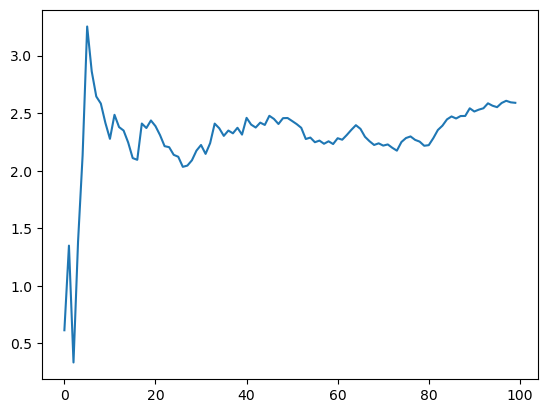

In [437]:
plt.plot(output_history)

Text(0.5, 1.0, 'sample path of $W_t$')

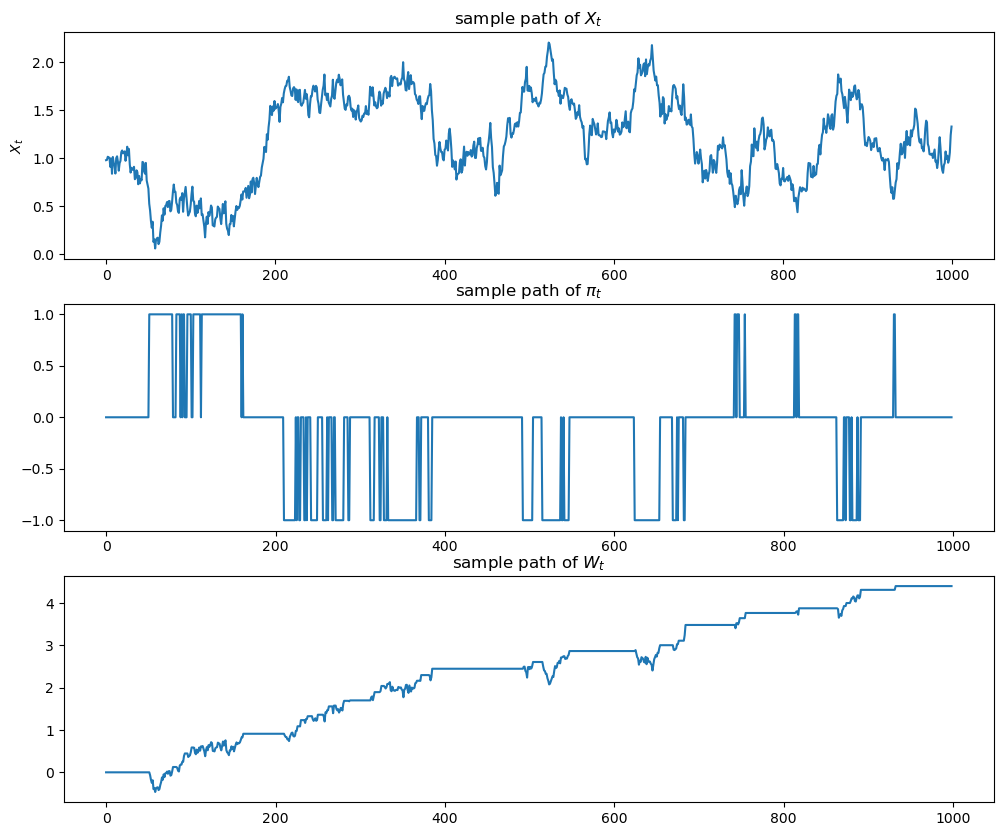

In [489]:
#state, _ = env.reset(seed=seed)
#env.seed(seed)
#env.action_space.seed(seed)
#torch.manual_seed(seed)
#np.random.seed(seed)
state, _ = env.reset()

done = False
val_predictions = []
while not done:
    #state = torch.FloatTensor(state[:N]).unsqueeze(0)
    state = dict_to_features(state)
    #action = policy.select_action(np.array(state))
    action  = agent.act(state)
    #val_predictions.append(value_pred.detach().item())
    state, reward, done, _ = env.step([action_to_portfolio[action]])
    
fig, ax = plt.subplots(3,1,figsize=(12,10))
#fig.suptitle(fr'One asset reinforcement learning agent $\theta$: {env.process.theta.item()}, $\sigma$: {env.process.sigma.item()}', fontsize=16, y = 0.97)
# plot a sample path of the wealth
ax[0].plot(env.X.transpose())
ax[0].set_title(r'sample path of $X_t$')
ax[0].set_ylabel(r'$X_t$')
#ax[0].set_xlabel('Time')
ax[1].plot(np.array(env.alloc).sum(axis=1).reshape(-1))
ax[1].set_title(r'sample path of $\pi_t$')

ax[2].plot(env.W[:-1])
ax[2].set_title(r'sample path of $W_t$')

#### 3.4 twin delayed deep deterministic policy gradient (TD3)

In [42]:
p = np.ones(N)
#process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
#N = 1
process = OU_process_shuffler(N,T,L)
r = 0.0
tc = 0.0
env = TradingEnvironment(process,T,r,p,mode='portfolio', max_pi=1, max_change=1,initial_wealth=0, transaction_costs=tc)

In [ ]:
def eval_runs_TD3(eps, frame):
    """
    Makes an evaluation run with the current epsilon
    """
    #env = gym.make("CartPole-v0")
    p = np.ones(N)
    #process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
    #N = 1
    process = OU_process_shuffler(N,T,L)
    r = 0.0
    tc = 0.0
    env = TradingEnvironment(process,T,r,p,mode='portfolio', max_pi=1, max_change=1,initial_wealth=0, transaction_costs=tc)

    reward_batch = []
    for i in range(5):
        state, _ = env.reset()
        state = dict_to_features(state)
        rewards = 0
        while True:
            action = agent.act(state, eps)
            state, reward, done, _ = env.step([action_to_portfolio[action]])
            state = dict_to_features(state)
            rewards += reward
            if done:
                break
        reward_batch.append(rewards)

In [424]:
import numpy as np
import torch
import os
from TD3 import *

def eval_policy(policy, env, seed, eval_episodes=1):
	
	avg_reward = 0.
	for ep in range(eval_episodes):
		state, _ = env.reset(seed + 100*ep)
		state = dict_to_features(state)
		done  = False
		while not done:
			action = policy.select_action(np.array(state))
			state, reward, done, _ = env.step(action)
			state = dict_to_features(state)
			avg_reward += reward

	avg_reward /= eval_episodes

	#print("---------------------------------------")
	#print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
	#print("---------------------------------------")
	return avg_reward

# PARAMETERS
seed = 100
alpha = 0.99 # Discount factor
tau  = 0.005 # Target network update rate

#p = np.ones(N)
#process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
#N = 1
#process = OU_process_shuffler(N,T,L)
#r = 0.0
#tc = 0.0
#env = TradingEnvironment(process,T,r,p,mode='intensity', max_pi=100, max_change=20,initial_wealth=0, transaction_costs=tc)

p = np.ones(N)
#process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
#N = 1
process = OU_process_shuffler(N,T,L)
r = 0.0
tc = 0.0
env = TradingEnvironment(process,T,r,p,mode='portfolio', max_pi=1, max_change=1,initial_wealth=0, transaction_costs=tc)

HIDDEN_DIM = 64

POLICY_NOISE =  0.2 # Noise added to target policy during critic update
MAX_ACTION = 20
POLICY_FREQ = 2 # Frequency of delayed policy updates
MAX_TIMESTEPS = 100000 # Max time steps to run environment
EXPL_NOISE = 0.1 # Std of Gaussian exploration noise
START_TIMESTEPS = 5000 #25e3 # Time steps initial random policy is used
NOISE_CLIP =  0.5 # Range to clip target policy noise
BATCH_SIZE = 256 # Batch size for both actor and critic
EVAL_FREQ = 5e3  # How often (time steps) we evaluate

SAVE_MODEL = True
file_name = 'N1'

# Set seeds
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

state_dim = 4*N # env.observation_space.shape[0]
action_dim = env.action_space.shape[0] 
max_action = float(env.action_space.high[0])

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": alpha,
    "tau": tau,
    'hidden_dimension': HIDDEN_DIM
}

# Initialize policy
kwargs["policy_noise"] = POLICY_NOISE * MAX_ACTION
kwargs["noise_clip"] = NOISE_CLIP * MAX_ACTION
kwargs["policy_freq"] = POLICY_FREQ
policy = TD3(**kwargs)

#policy.load(f"./models/{policy_file}")

replay_buffer = ReplayBuffer_TD3(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy, env, seed)]

state,_ = env.reset()
state = dict_to_features(state)

done   = False
score = 0
episode_timesteps = 0
episode_num = 0

scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
episode_num = 0

for t in range(int(MAX_TIMESTEPS)):
    
    episode_timesteps += 1

    # Select action randomly or according to policy
    if t < START_TIMESTEPS:
        action = env.action_space.sample()
    else:
        action = (
            policy.select_action(np.array(state))
            + np.random.normal(0, MAX_ACTION * EXPL_NOISE, size=action_dim)
        ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done, _ = env.step(action)
    next_state = dict_to_features(next_state)
    #done_bool = float(done) if episode_timesteps < env.L else 0
    done_bool = float(done)
    # Store data in replay buffer
    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    score += reward

    # Train agent after collecting sufficient data
    if t >= START_TIMESTEPS:
        policy.train(replay_buffer, BATCH_SIZE)

    # Evaluate episode
    if (t + 1) % EVAL_FREQ == 0:
        evaluations.append(eval_policy(policy, env, seed))
        env.reset()
        np.save(f"{os.getcwd()}/results/{file_name}", evaluations)
        if SAVE_MODEL: policy.save(f"{os.getcwd()}/models/{file_name}")
    
    if done:
        #scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        #output_history.append(np.mean(scores_window))
        eval_score = eval_policy(policy, env, seed,eval_episodes=1)
        scores_window.append(eval_score)       # save most recent score
        output_history.append(np.mean(scores_window))
        print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, t, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tFrame {}\tAverage Score: {:.2f}'.format(i_episode,t, np.mean(scores_window)))
        i_episode +=1 
        state, _ = env.reset()
        state = dict_to_features(state)
        score = 0
        episode_timesteps = 0
        episode_num += 1 

/opt/anaconda3/envs/deep_learning/lib/python3.8/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode 200	Frame 19994	Average Score: 0.811
Episode 280	Frame 99994 	Average Score: 2.47

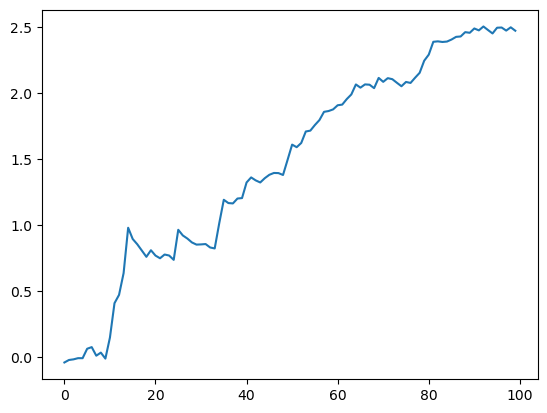

In [425]:
plt.plot(output_history)

Text(0.5, 1.0, 'sample path of $W_t$')

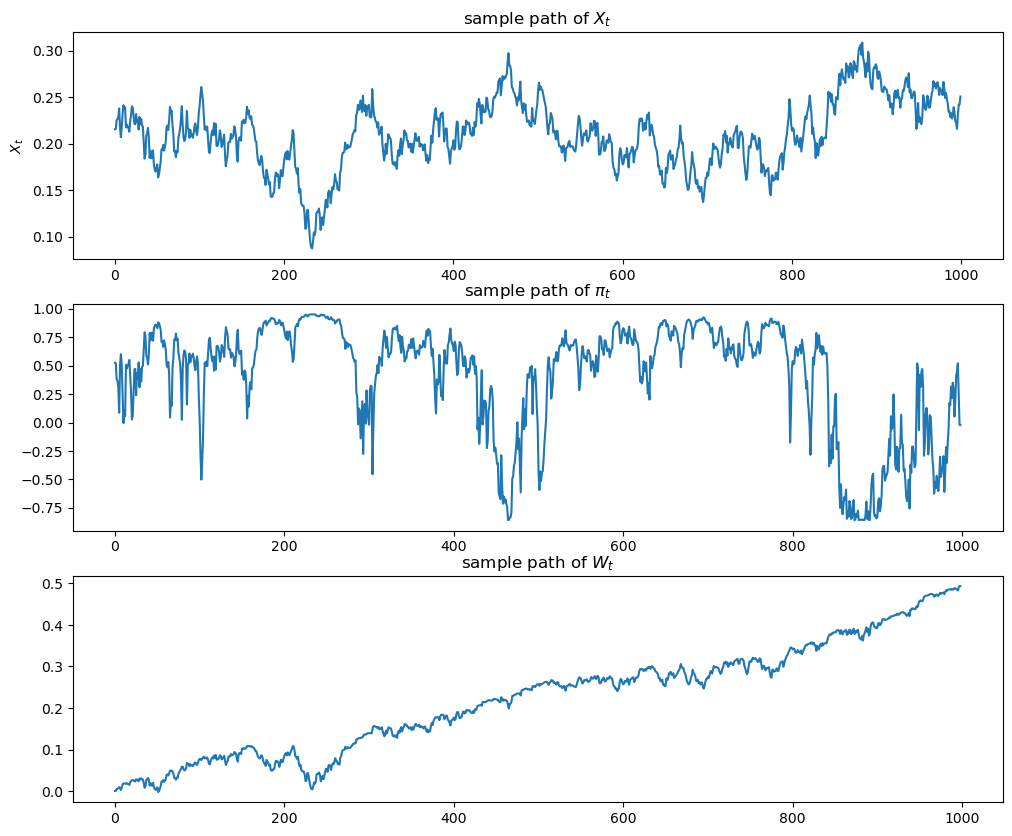

In [441]:
state, _ = env.reset()
done = False
val_predictions = []
while not done:
    #state = torch.FloatTensor(state[:N]).unsqueeze(0)
    state = dict_to_features(state)

    action = policy.select_action(np.array(state))
    #val_predictions.append(value_pred.detach().item())
    state, reward, done, _ = env.step(action)
    
fig, ax = plt.subplots(3,1,figsize=(12,10))
#fig.suptitle(fr'One asset reinforcement learning agent $\theta$: {env.process.theta.item()}, $\sigma$: {env.process.sigma.item()}', fontsize=16, y = 0.97)
# plot a sample path of the wealth
ax[0].plot(env.X.transpose())
ax[0].set_title(r'sample path of $X_t$')
ax[0].set_ylabel(r'$X_t$')
#ax[0].set_xlabel('Time')
ax[1].plot(np.array(env.alloc).sum(axis=1).reshape(-1))
ax[1].set_title(r'sample path of $\pi_t$')

ax[2].plot(env.W[:-1])
ax[2].set_title(r'sample path of $W_t$')

#### 3.5 Quantile regression DQN (QR-DQN)

In [ ]:
def dict_to_features(d):
    #return torch.FloatTensor(d['values']).unsqueeze(0).numpy()
    #return torch.FloatTensor([*d['values'], *d['portfolio'], d['wealth']])
    #return torch.FloatTensor([*d['values'], *d['portfolio']])
	return torch.FloatTensor([*d['values'], *d['mu'],*d['sigma'],*d['theta']])

In [ ]:
from QR_DQN import DQN_Agent 

# PARAMETERS
seed = 100
alpha = 0.99 # Discount factor
tau  = 0.005 # Target network update rate

#p = np.ones(N)
#process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
#N = 1
#process = OU_process_shuffler(N,T,L)
#r = 0.0
#tc = 0.0
#env = TradingEnvironment(process,T,r,p,mode='intensity', max_pi=100, max_change=20,initial_wealth=0, transaction_costs=tc)

p = np.ones(N)
#process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
#N = 1
process = OU_process_shuffler(N,T,L)
r = 0.0
tc = 0.0
env = TradingEnvironment(process,T,r,p,mode='portfolio', max_pi=1, max_change=1,initial_wealth=0, transaction_costs=tc)

#writer = SummaryWriter("runs/"+"DQN_LL_new_1")
frames = 100000
seed = 10
BUFFER_SIZE = 10000
BATCH_SIZE = 60
GAMMA = 0.99
TAU = 1e-2
eps_frames=5000
min_eps=0.025
LR = 1e-3
UPDATE_EVERY = 1
n_step = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = True
file_name = 'N1'

# Set seeds
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# action_size     = env.action_space.n #### going to fix this
action_size       = 3
#state_size        = env.observation_space.shape
state_size        = [4]

agent = DQN_Agent(state_size=state_size,    
                    action_size=action_size,
                    Network="DDQN",
                    layer_size=256,
                    n_step=n_step,
                    BATCH_SIZE=BATCH_SIZE, 
                    BUFFER_SIZE=BUFFER_SIZE, 
                    LR=LR, 
                    TAU=TAU, 
                    GAMMA=GAMMA, 
                    UPDATE_EVERY=UPDATE_EVERY, 
                    device=device, 
                    seed=seed)

##########################
action_to_portfolio = {0:-1, 1:0, 2: 1}
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1
state, _ = env.reset()
state = dict_to_features(state)
score = 0                  
for frame in range(1, frames+1):

    action = agent.act(state, eps)
    
    next_state, reward, done, _ = env.step([action_to_portfolio[action]])
    next_state = dict_to_features(next_state)
    agent.step(state, action, reward, next_state, done)#, writer)
    state = next_state
    score += reward
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)

    # evaluation runs
    if frame % 1000 == 0:
        eval_runs(eps, frame)
    
    if done:
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tFrame {}\tAverage Score: {:.2f}'.format(i_episode,frame, np.mean(scores_window)))
        i_episode +=1 
        state, _ = env.reset()
        state = dict_to_features(state)
        score = 0            
######

Using  cpu
QR_DQN(
  (head_1): Linear(in_features=4, out_features=256, bias=True)
  (ff_1): Linear(in_features=256, out_features=256, bias=True)
  (ff_2): Linear(in_features=256, out_features=96, bias=True)
)


/opt/anaconda3/envs/deep_learning/lib/python3.8/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode 100	Frame 99900	Average Score: 1.344


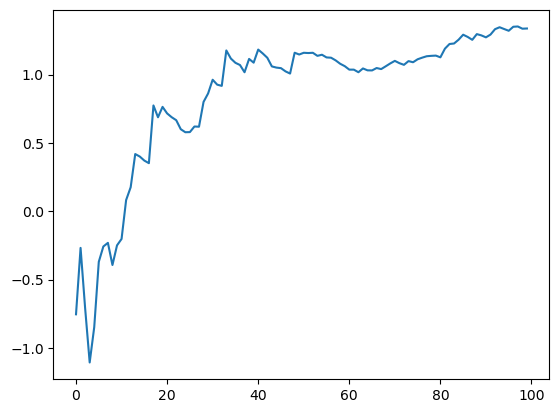

In [ ]:
plt.plot(output_history)

Text(0.5, 1.0, 'sample path of $W_t$')

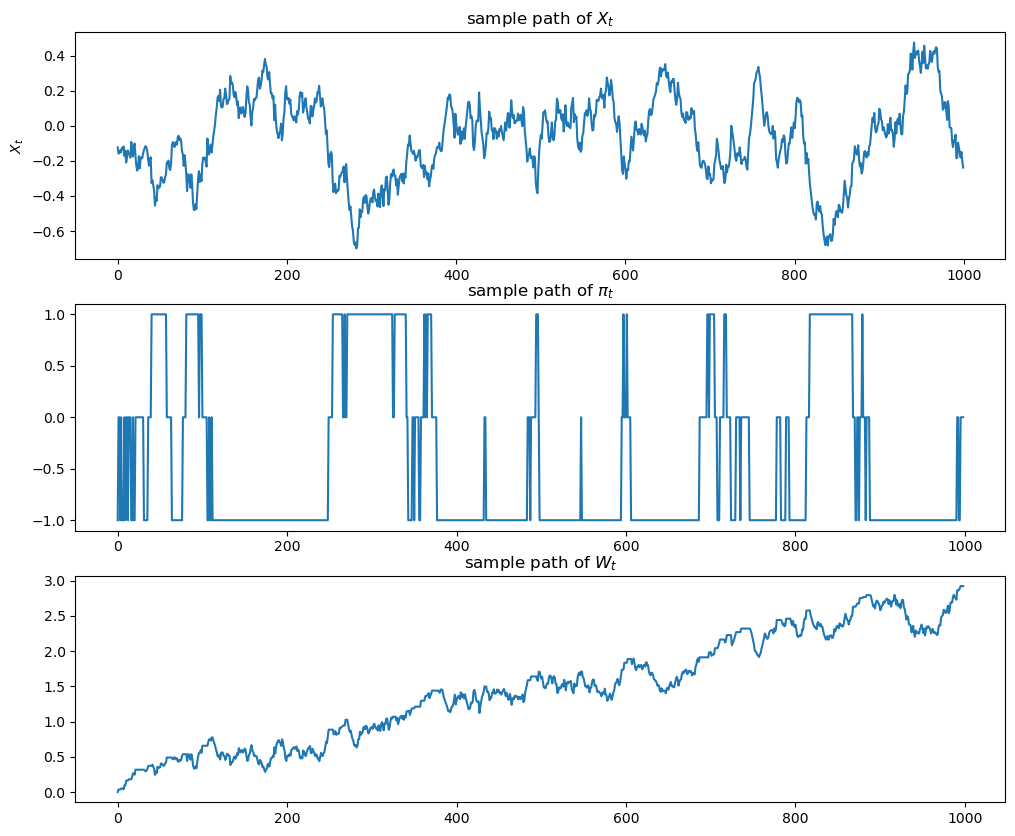

In [ ]:
seed = np.random.randint(0,100000)
state, _ = env.reset(seed=seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
done = False
val_predictions = []
while not done:
    #state = torch.FloatTensor(state[:N]).unsqueeze(0)
    state = dict_to_features(state)
    #action = policy.select_action(np.array(state))
    action  = agent.act(state)
    #val_predictions.append(value_pred.detach().item())
    state, reward, done, _ = env.step([action_to_portfolio[action]])
    
fig, ax = plt.subplots(3,1,figsize=(12,10))
#fig.suptitle(fr'One asset reinforcement learning agent $\theta$: {env.process.theta.item()}, $\sigma$: {env.process.sigma.item()}', fontsize=16, y = 0.97)
# plot a sample path of the wealth
ax[0].plot(env.X.transpose())
ax[0].set_title(r'sample path of $X_t$')
ax[0].set_ylabel(r'$X_t$')
#ax[0].set_xlabel('Time')
ax[1].plot(np.array(env.alloc).sum(axis=1).reshape(-1))
ax[1].set_title(r'sample path of $\pi_t$')

ax[2].plot(env.W[:-1])
ax[2].set_title(r'sample path of $W_t$')

Text(0.5, 1.0, 'sample path of $W_t$')

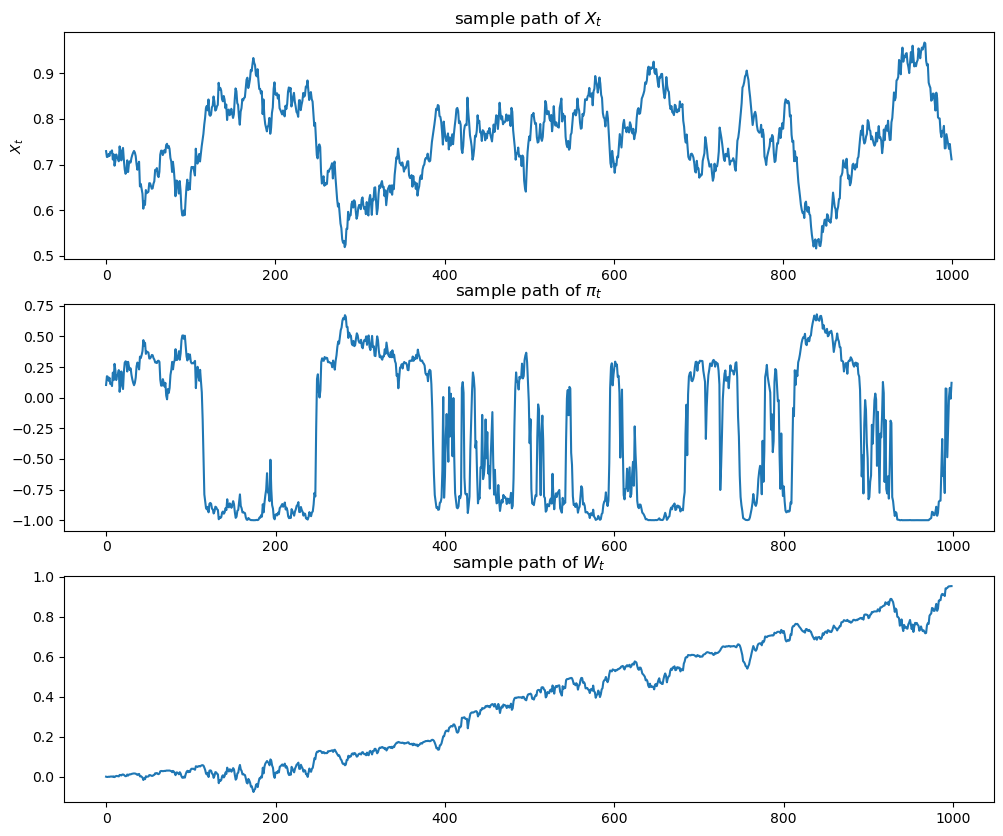

In [ ]:
state, _ = env.reset(seed=seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
done = False
val_predictions = []
while not done:
    #state = torch.FloatTensor(state[:N]).unsqueeze(0)
    state = dict_to_features(state)

    action = policy.select_action(np.array(state))
    #val_predictions.append(value_pred.detach().item())
    state, reward, done, _ = env.step(action)
    
fig, ax = plt.subplots(3,1,figsize=(12,10))
#fig.suptitle(fr'One asset reinforcement learning agent $\theta$: {env.process.theta.item()}, $\sigma$: {env.process.sigma.item()}', fontsize=16, y = 0.97)
# plot a sample path of the wealth
ax[0].plot(env.X.transpose())
ax[0].set_title(r'sample path of $X_t$')
ax[0].set_ylabel(r'$X_t$')
#ax[0].set_xlabel('Time')
ax[1].plot(np.array(env.alloc).sum(axis=1).reshape(-1))
ax[1].set_title(r'sample path of $\pi_t$')

ax[2].plot(env.W[:-1])
ax[2].set_title(r'sample path of $W_t$')

In [210]:
def dict_to_features(d):
    #return torch.FloatTensor(d['values']).unsqueeze(0).numpy()
    #return torch.FloatTensor([*d['values'], *d['portfolio'], d['wealth']])
    #return torch.FloatTensor([*d['values'], *d['portfolio']])
	return torch.FloatTensor([*d['values'], *d['mu'],*d['sigma'],*d['theta']])

In [447]:
from QR_DQN import DQN_Agent 

# PARAMETERS
seed = 100
alpha = 0.99 # Discount factor
tau  = 0.005 # Target network update rate

#p = np.ones(N)
#process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
#N = 1
#process = OU_process_shuffler(N,T,L)
#r = 0.0
#tc = 0.0
#env = TradingEnvironment(process,T,r,p,mode='intensity', max_pi=100, max_change=20,initial_wealth=0, transaction_costs=tc)

p = np.ones(N)
#process = ornstein_uhlenbeck_process(theta,mu,sigma,delta_t)
#N = 1
process = OU_process_shuffler(N,T,L)
r = 0.0
tc = 0.0
env = TradingEnvironment(process,T,r,p,mode='portfolio', max_pi=1, max_change=1,initial_wealth=0, transaction_costs=tc)

#writer = SummaryWriter("runs/"+"DQN_LL_new_1")
frames = 100000
seed = 10
BUFFER_SIZE = 10000
BATCH_SIZE = 60
GAMMA = 0.99
TAU = 1e-2
eps_frames=5000
min_eps=0.025
LR = 1e-3
UPDATE_EVERY = 1
n_step = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using ", device)
eps_fixed = False
SAVE_MODEL = True
file_name = 'N1'

# Set seeds
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

# action_size     = env.action_space.n #### going to fix this
action_size       = 3
#state_size        = env.observation_space.shape
state_size        = [4]

agent = DQN_Agent(state_size=state_size,    
                    action_size=action_size,
                    Network="DDQN",
                    layer_size=256,
                    n_step=n_step,
                    BATCH_SIZE=BATCH_SIZE, 
                    BUFFER_SIZE=BUFFER_SIZE, 
                    LR=LR, 
                    TAU=TAU, 
                    GAMMA=GAMMA, 
                    UPDATE_EVERY=UPDATE_EVERY, 
                    device=device, 
                    seed=seed)

##########################
action_to_portfolio = {0:-1, 1:0, 2: 1}
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
output_history = []
frame = 0
if eps_fixed:
    eps = 0
else:
    eps = 1
eps_start = 1
i_episode = 1
state, _ = env.reset()
state = dict_to_features(state)
score = 0                  
for frame in range(1, frames+1):

    action = agent.act(state, eps)
    
    next_state, reward, done, _ = env.step([action_to_portfolio[action]])
    next_state = dict_to_features(next_state)
    agent.step(state, action, reward, next_state, done)#, writer)
    state = next_state
    score += reward
    # linear annealing to the min epsilon value until eps_frames and from there slowly decease epsilon to 0 until the end of training
    if eps_fixed == False:
        if frame < eps_frames:
            eps = max(eps_start - (frame*(1/eps_frames)), min_eps)
        else:
            eps = max(min_eps - min_eps*((frame-eps_frames)/(frames-eps_frames)), 0.001)

    # evaluation runs
    if frame % 1000 == 0:
        eval_runs(eps, frame)
    
    if done:
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        #writer.add_scalar("Average100", np.mean(scores_window), frame)
        output_history.append(np.mean(scores_window))
        print('\rEpisode {}\tFrame {} \tAverage Score: {:.2f}'.format(i_episode, frame, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tFrame {}\tAverage Score: {:.2f}'.format(i_episode,frame, np.mean(scores_window)))
        i_episode +=1 
        state, _ = env.reset()
        state = dict_to_features(state)
        score = 0            
######

Using  cpu
QR_DQN(
  (head_1): Linear(in_features=4, out_features=256, bias=True)
  (ff_1): Linear(in_features=256, out_features=256, bias=True)
  (ff_2): Linear(in_features=256, out_features=96, bias=True)
)


/opt/anaconda3/envs/deep_learning/lib/python3.8/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode 100	Frame 99900	Average Score: 1.344


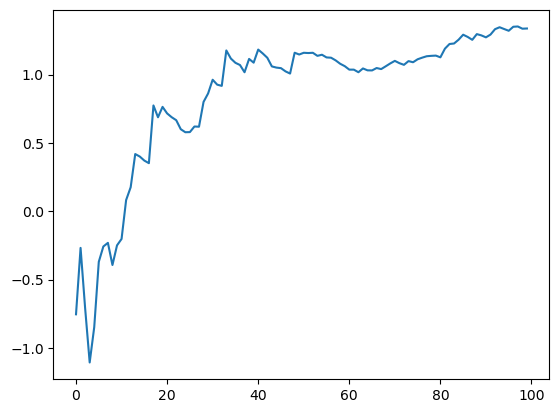

In [448]:
plt.plot(output_history)

Text(0.5, 1.0, 'sample path of $W_t$')

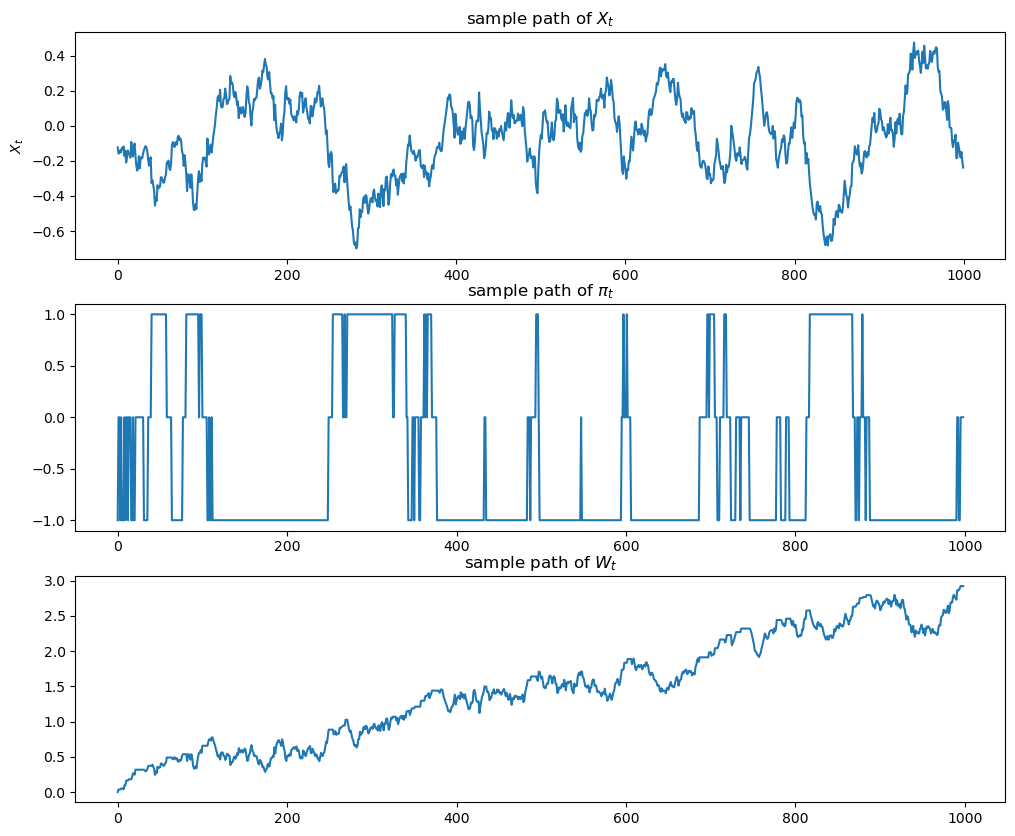

In [480]:
seed = np.random.randint(0,100000)
state, _ = env.reset(seed=seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
done = False
val_predictions = []
while not done:
    #state = torch.FloatTensor(state[:N]).unsqueeze(0)
    state = dict_to_features(state)
    #action = policy.select_action(np.array(state))
    action  = agent.act(state)
    #val_predictions.append(value_pred.detach().item())
    state, reward, done, _ = env.step([action_to_portfolio[action]])
    
fig, ax = plt.subplots(3,1,figsize=(12,10))
#fig.suptitle(fr'One asset reinforcement learning agent $\theta$: {env.process.theta.item()}, $\sigma$: {env.process.sigma.item()}', fontsize=16, y = 0.97)
# plot a sample path of the wealth
ax[0].plot(env.X.transpose())
ax[0].set_title(r'sample path of $X_t$')
ax[0].set_ylabel(r'$X_t$')
#ax[0].set_xlabel('Time')
ax[1].plot(np.array(env.alloc).sum(axis=1).reshape(-1))
ax[1].set_title(r'sample path of $\pi_t$')

ax[2].plot(env.W[:-1])
ax[2].set_title(r'sample path of $W_t$')

Text(0.5, 1.0, 'sample path of $W_t$')

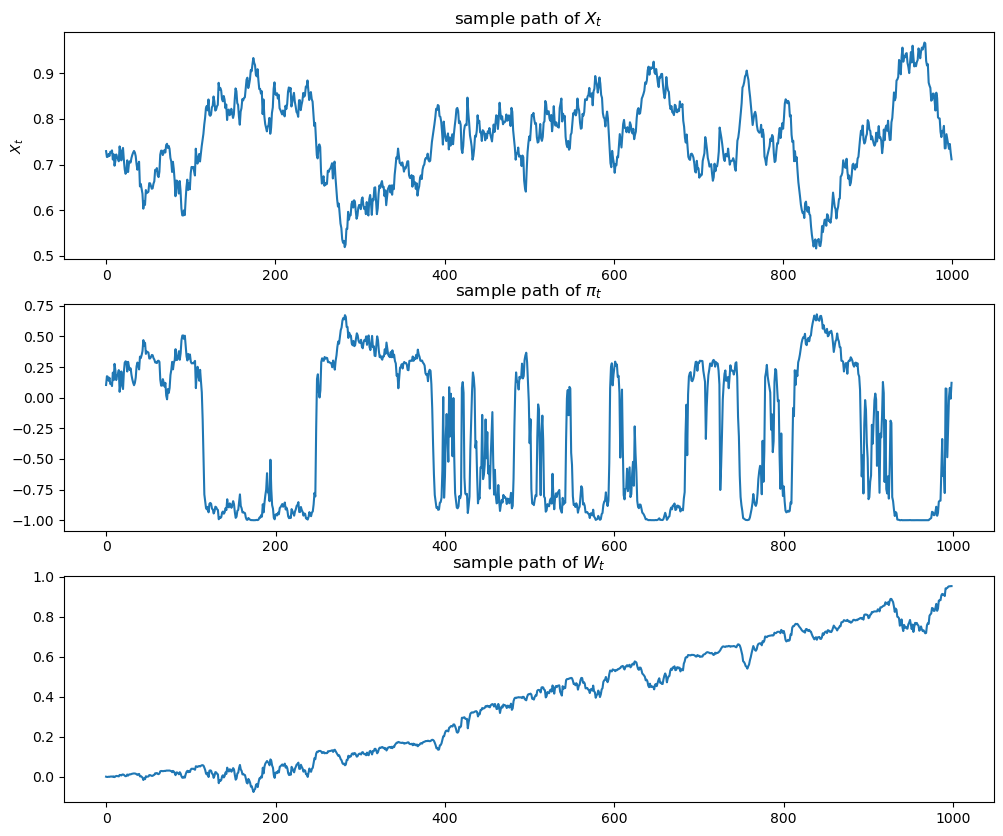

In [481]:
state, _ = env.reset(seed=seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
done = False
val_predictions = []
while not done:
    #state = torch.FloatTensor(state[:N]).unsqueeze(0)
    state = dict_to_features(state)

    action = policy.select_action(np.array(state))
    #val_predictions.append(value_pred.detach().item())
    state, reward, done, _ = env.step(action)
    
fig, ax = plt.subplots(3,1,figsize=(12,10))
#fig.suptitle(fr'One asset reinforcement learning agent $\theta$: {env.process.theta.item()}, $\sigma$: {env.process.sigma.item()}', fontsize=16, y = 0.97)
# plot a sample path of the wealth
ax[0].plot(env.X.transpose())
ax[0].set_title(r'sample path of $X_t$')
ax[0].set_ylabel(r'$X_t$')
#ax[0].set_xlabel('Time')
ax[1].plot(np.array(env.alloc).sum(axis=1).reshape(-1))
ax[1].set_title(r'sample path of $\pi_t$')

ax[2].plot(env.W[:-1])
ax[2].set_title(r'sample path of $W_t$')